<a href="https://colab.research.google.com/github/nadyayal/Causalinference/blob/master/causal_cross_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install causalinference

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 2.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# causal inference
from causalinference import CausalModel

In [ ]:
def read_data_CMod():
    print('Reading CMod data...')
    cmod = pd.read_csv('/content/drive/MyDrive/iaea/python_cross/new_data_CMod_VDE.csv')
    # read shotlist
    VDEshotlist = pd.read_csv('/content/drive/MyDrive/iaea/python_cross/VDE_shotlist.txt')
    VDEshotlist.to_csv('VDE_shotlist.csv')
    vdeshots = pd.read_csv('VDE_shotlist.csv', index_col=None, header=None)
    return cmod, vdeshots

def define_indices_CMod(cmod):
    # Define indices
    # Define indices of missing objects
    print('Definig indices...')
    indices_no_disrupt = list(cmod[cmod.Time2Disr.isnull()].index)
    indices_disrupt = list(cmod[~cmod.Time2Disr.isnull()].index)
    # Define indices of disruption happened
    indices_flattop = list(cmod[abs(cmod.dipprog_dt) <= 1.e3].index)
    indices_disrupt_time = list(cmod[cmod.Time2Disr <= 3e-3].index)
    return indices_no_disrupt, indices_disrupt, indices_flattop, indices_disrupt_time

def indices_operation(machine_param, shots_list, indices_no_disrupt, indices_disrupt, indices_flattop, 
                      indices_disrupt_time, name, exp):
    print('Operations with indices are in progress...')
    # find indices of the rows when ecactly the disruption happend in the flattop data, same as indices_disrupt_time    
    indices_disrupt_time_in_flattop = list(np.intersect1d(indices_disrupt_time, indices_flattop)) 
    # find indices of the whole shot numbers which end in disruption
    indices_disrupt_in_flattop = list(machine_param.Shot[np.isin(machine_param.Shot, machine_param.Shot[
        indices_disrupt_time_in_flattop])].index) 
    # find indices of the whole shot numbers in the database which end in disruption in the flattop data
    indices_flattop_disrupt_in_flattop = list(np.intersect1d(indices_flattop, indices_disrupt_in_flattop))
    # find indices of non disruptive shots 
    indices_flattop_no_disrupt = list(np.intersect1d(indices_flattop, indices_no_disrupt))
    
    # for ease of reference we named them in this way
    ii = indices_flattop_no_disrupt
    ff = indices_flattop_disrupt_in_flattop
    if name == '_TCV':
        # reading other disruptions daa file
        other_disruptions = list(
            machine_param.loc[machine_param['filename'] == '/content/drive/MyDrive/iaea/python_cross/Lite_Table_TCV_Disruptions_0.csv'].index)  
        # all VDE/VD data reading
        if exp == 'VD':
            all_exp_file = machine_param.loc[machine_param['filename'] == '/content/drive/MyDrive/iaea/python_cross/Lite_Table_TCV_Disruptions_VD.csv']
        if exp == 'VDE':
            all_exp_file = machine_param.loc[machine_param['filename'] == '/content/drive/MyDrive/iaea/python_cross/Lite_Table_TCV_Disruptions_VDE.csv']
        # jj - flattop VDE/VD disruptions that are in vd(e)shotlist, idx is choosing Shots from VDE/VD data which are in the vd(e)shots with Ip>50kA
        idx = list(all_exp_file.Shot[np.isin(all_exp_file.Shot, shots_list)].index)
        # subselect flattop phase of disruptive data, part of shotlist
        jj = list(np.intersect1d(ff, idx))
        # all data is flattop, so other_disruptions=other_disruptions_flattop
        other_disruptions_flattop = other_disruptions
        # include data for VDEs flattop where time_until_disrupt<=40ms
        jj_before_40= list(np.intersect1d(jj, list(all_exp_file[all_exp_file.Time2Disr <= 0.04].index)))    
        # isolate for VDE shots behavior around 50ms before disruption
        jj_50 = list(np.intersect1d(jj, all_exp_file.loc[
            (all_exp_file['Time2Disr'] >= 0.04) & (all_exp_file['Time2Disr'] <= 0.06)].index))  

    if name == '_CMod':
        # find indices in shot variable that coincide with shot numbers in shotlist
        idx = list(machine_param.Shot[np.isin(machine_param.Shot, shots_list)].index)
        # subselect flattop phase of disruptive data, part of VDE shotlist
        jj = list(np.intersect1d(ff, idx))      
        # include data for VDEs flattop where time_until_disrupt<=40ms
        jj_before_40 = list(np.intersect1d(jj, list(machine_param[machine_param.Time2Disr <= 0.04].index)))    
        # isolate for VDE shots behavior around 50ms before disruption
        jj_50 = list(np.intersect1d(jj, machine_param.loc[
            (machine_param['Time2Disr'] >= 0.04) & (machine_param['Time2Disr'] <= 0.06)].index))  
        # all flattop disruptions
        disruption = list(machine_param.Shot[ff])   
        # shotlist of all other flattop disruptions that are not VDEs
        shotlist_disruptions = np.unique(disruption)         
        other_disruptions = list(shotlist_disruptions[~np.isin(shotlist_disruptions, shots_list)]) 
        # indices of all flattop disruptions that are not VDEs
        other_disruptions_flattop = list(machine_param.Shot[np.isin(machine_param.Shot, other_disruptions)].index)   
        # flattop indices of all flattop disruptions that are not VDEs
        # jj2 = (np.intersect1d(ff,other_disruptions_flattop)).tolist()       
        # since the whole data is flattop all_other_disruptions is equal to jj2 which is flattop not vde disruptions
    # concatenate indices in the denominator:
    denom_idx = np.concatenate((ii, other_disruptions_flattop, jj_before_40), axis=0)     
    return jj_50, denom_idx, ii

work_type = input('Which installation do you want to choose?\
\n - Input 1 if TCV \
\n - Input 2 if CMod \ -->')
if work_type == '1':
    # function that drops some columns to fasten the data procession and saves the results in the new "Lite" versions 
    # fasten_TCV()
    name = '_TCV'
    # takes shots with VD or VDE flag from TCV_parameters.xlsx
    exp = input('Do you want to study VD or VDE? (input VD or VDE) -->').upper()
    all_data, shots_list = read_data_TCV(exp)
    indices_no_disrupt, indices_disrupt, indices_flattop, indices_disrupt_time = define_indices_TCV(all_data)
    jj_50, denom_idx = indices_operation(all_data, shots_list, indices_no_disrupt, indices_disrupt, 
                                         indices_flattop, indices_disrupt_time, name, exp)
    # sampling rate
    deltat = 0.002

if work_type == '2':
    name = '_CMod'
    exp = "VDE"
    all_data, shots_list = read_data_CMod()
    indices_no_disrupt, indices_disrupt, indices_flattop, indices_disrupt_time = define_indices_CMod(all_data)
    jj_50, denom_idx, ii = indices_operation(all_data, shots_list, indices_no_disrupt, indices_disrupt, 
                                         indices_flattop, indices_disrupt_time, name, exp)
    # sampling rate
    deltat = 0.005

Which installation do you want to choose?
 - Input 1 if TCV 
 - Input 2 if CMod \ -->2
Reading CMod data...
Definig indices...
Operations with indices are in progress...


In [ ]:
D = pd.concat([pd.Series(data=[0]*len(ii), index=ii),
               pd.Series(data=[1]*len(jj_50), index = jj_50)]).sort_index()  # if index is in jj_50 - than 1, if not - 0 - (now just for not disruptive)
params = {'DELTA_BOTTOM', 'DELTA', 'DELTA_TOP', 'GAP_in', 'I_P', 'LI', 'KAPPA', 'GAP_out', 'BETAN',  'Q95'}

In [ ]:
X = pd.concat([all_data[params].iloc[ii], all_data[params].iloc[jj_50]]).sort_index() #now just for not disruptive
X.loc[X.I_P<0] == abs(X.loc[X.I_P<0])
Y = X['BETAN']
causal = CausalModel(Y, D, X) #now just for not disruptive
df_ndiff = pd.DataFrame(causal.summary_stats['ndiff'], columns={'normalized_diff'})
print(abs(df_ndiff).sort_values(by='normalized_diff'))

              normalized_diff
DELTA_TOP            0.020817
GAP_in               0.063160
LI                   0.081500
BETAN                0.113616
I_P                  0.143148
KAPPA                0.184401
DELTA                0.233334
DELTA_BOTTOM         0.294222
Q95                  0.353434
GAP_out              0.410439


In [ ]:
param = ['BETAN', 'GAP_out', 'Q95', 'DELTA_BOTTOM', 'DELTA']

In [ ]:
X = pd.concat([all_data[params].iloc[ii], all_data[params].iloc[jj_50]]).sort_index()
Y = X[param[0]]
if Y.name == 'BETAN':
  range_ = [0, 1.5]
if Y.name == 'KAPPA':
  range_ = [0.8, 2.0]
if Y.name == 'GAP_in':
  range_ = [0.05, 0.25]
if Y.name == 'GAP_out':
  range_ = [0, 0.2]
if Y.name == 'Q95':
  range_ = [2, 7.5]
if Y.name == 'I_P':
  range_ = [-1.5e6, 1.5e6]
if Y.name == 'DELTA':
  DELTA_range = [-0.2, 0.8]
if Y.name == 'DELTA_TOP':
  DELTA_TOP_range = [-0.2, 0.8]
if Y.name == 'DELTA_BOTTOM':
  DELTA_BOTTOM_range = [-0.2 ,0.8]
if Y.name == 'LI':
  range_ = [ 0.75, 2.25] 
range_split = (range_[0]+range_[1])/3
Y_1 = Y.loc[(Y>=range_[0]) & (Y<=range_split)]
Y_2 = Y.loc[(Y>range_split) & (Y<=range_[1])]
D_1 = D[Y_1.index]  # if index is in jj_50 - than 1, if not - 0
D_2 = D[Y_2.index]  # if index is in jj_50 - than 1, if not - 0
X_1 = X[X.index.isin(Y_1.index)]
X_2 = X[X.index.isin(Y_2.index)]
X_1 = X_1.drop(param[0], axis=1)
cm_1 = CausalModel(Y_1.values, D_1.values, X_1.values)
print(f"{range_[0]} < Y < {range_split}")
print(cm_1.summary_stats)
X_2 = X_2.drop(param[0], axis=1)
cm_2 = CausalModel(Y_2.values, D_2.values, X_2.values)
print(f"{range_[1]} > Y > {range_split}")
print(cm_2.summary_stats)

0 < Y < 0.5

Summary Statistics

                    Controls (N_c=286295)         Treated (N_t=611)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.289        0.096        0.289        0.110       -0.000

                    Controls (N_c=286295)         Treated (N_t=611)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.056        0.016        0.064        0.022        0.398
             X1        1.441        0.138        1.478        0.196        0.217
             X2        0.408        0.058        0.389        0.087       -0.252
             X3        0.462        0.124        0.424        0.144       -0.280
             X4        0.101        0.015        0.102        0.023        

In [ ]:
df_ndiff_1 = pd.DataFrame(cm_1.summary_stats['ndiff'], index=X_1.columns, columns={'normalized_diff'})
print(abs(df_ndiff_1).sort_values(by='normalized_diff'))
df_ndiff_2 = pd.DataFrame(cm_2.summary_stats['ndiff'],index=X_2.columns, columns={'normalized_diff'})
print(abs(df_ndiff_2).sort_values(by='normalized_diff'))

              normalized_diff
DELTA_TOP            0.003444
GAP_in               0.058485
I_P                  0.100931
KAPPA                0.162116
LI                   0.216804
Q95                  0.242241
DELTA                0.252053
DELTA_BOTTOM         0.280313
GAP_out              0.398036
              normalized_diff
GAP_in               0.079805
DELTA_TOP            0.089081
DELTA                0.091126
KAPPA                0.198040
DELTA_BOTTOM         0.232967
I_P                  0.251969
GAP_out              0.461336
LI                   0.676246
Q95                  0.740195


In [ ]:
'''param_to_drop = [['DELTA_TOP', 'GAP_in', 'I_P', 'KAPPA'], ['DELTA_TOP', 'GAP_in', 'DELTA', 'KAPPA']]
X_1 = X_1.drop(param_to_drop[0], axis=1)
X_2 = X_2.drop(param_to_drop[1], axis=1)
cm_1 = CausalModel(Y_1.values, D_1.values, X_1.values)
cm_2 = CausalModel(Y_2.values, D_2.values, X_2.values)'''


In [ ]:
cm_1 = CausalModel(Y_1.values, D_1.values, X_1.values)
cm_2 = CausalModel(Y_2.values, D_2.values, X_2.values)

In [ ]:
cm = [cm_1, cm_2]

In [ ]:
X_2.columns

Index(['GAP_out', 'LI', 'DELTA', 'DELTA_BOTTOM', 'GAP_in', 'I_P', 'Q95',
       'DELTA_TOP', 'KAPPA'],
      dtype='object')

In [ ]:
X_1 = X_1.drop({ 'DELTA_TOP'}, axis=1)
X_2 = X_2.drop({ 'DELTA_TOP'}, axis=1)

In [ ]:
X_1 = X_1.drop({ 'I_P'}, axis=1)
X_2 = X_2.drop({ 'I_P'}, axis=1)

In [ ]:
cm_1 = CausalModel(Y_1.values, D_1.values, X_1.values)
cm_2 = CausalModel(Y_2.values, D_2.values, X_2.values)
cm = [cm_1, cm_2]

After having a look at the coeffs we can get rid of I_P, DELTA TOP

In [ ]:
import multiprocessing

In [ ]:
for i in cm:
  print(f'Each model propensity - {i}')
  multiprocessing.Process(i.est_propensity())
  print(i.propensity)
  print(f'Each model propensity fitted - {i}') # contains the estimated propensity score of each subject
  print(i.propensity['fitted'])
  print(i.propensity['coef'])
  #i.trim_s()
  #print(f'Each model cutoff - {i}')
  #print(i.cutoff)

Each model propensity - <causalinference.causal.CausalModel object at 0x7fc49a5eb950>

Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -40.312      2.178    -18.512      0.000    -44.580    -36.044
            X0     70.788      4.304     16.448      0.000     62.353     79.223
            X1     10.385      0.479     21.683      0.000      9.446     11.323
            X2    -14.688      1.305    -11.252      0.000    -17.247    -12.130
            X3      2.028      0.503      4.030      0.000      1.042      3.015
            X4     19.342      4.177      4.630      0.000     11.155     27.529
            X5     -1.886      0.102    -18.485      0.000     -2.086     -1.686
            X6     16.296      1.205     13.523      0.000     13.934     18.658

Each model propensity fitted - <causalinference.causal.Causa

In [ ]:
prop_fit = [cm[0].propensity['fitted'], cm[1].propensity['fitted']]

In [ ]:
for i in cm:
  #print(i.summary_stats)
  print("Stratifying")
  i.stratify_s()
  print(i.strata)

  '''for j in i.strata:
    j.est_via_ols(adj=1)
    print(j.estimates)'''

Stratifying

Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.000     0.001    143318       136     0.001     0.001    -0.008
         2     0.001     0.002     71649        77     0.002     0.002    -0.012
         3     0.002     0.004     35769        94     0.003     0.003     0.013
         4     0.004     0.005     17879        53     0.004     0.005     0.036
         5     0.005     0.006      4471        12     0.006     0.006     0.020
         6     0.006     0.008      4452        31     0.007     0.007     0.055
         7     0.008     0.011      4440        43     0.009     0.009     0.015
         8     0.011     0.014      2203        38     0.012     0.012     0.028
         9     0.014     0.019      1098        23     0.016     0.017  

In [ ]:
X_1['propensity_score'] = cm[0].propensity['fitted']
X_2['propensity_score'] = cm[1].propensity['fitted']

With the sample divided into strata of units that have similar propensity scores, we should be able to get clean estimates of treatment effects within each block.

In [ ]:
stratas = [cm[0].strata[11], cm[1].strata[7]]
print(stratas[0].summary_stats) #we chose strata with the biggest Propensity score
print(stratas[1].summary_stats) #we chose strata with the biggest Propensity score


Summary Statistics

                       Controls (N_c=212)          Treated (N_t=68)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.186        0.136        0.322        0.096        0.137

                       Controls (N_c=212)          Treated (N_t=68)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.089        0.035        0.096        0.029        0.210
             X1        1.732        0.331        1.568        0.158       -0.632
             X2        0.319        0.148        0.247        0.108       -0.554
             X3        0.311        0.171        0.225        0.111       -0.595
             X4        0.111        0.045        0.121        0.039        0.239
      

In [ ]:
X_1['BETAN']=Y_1
X_2['BETAN']=Y_2

In [ ]:
s1 = stratas[0].summary_stats['Y_t_mean']-stratas[0].summary_stats['Y_t_sd']
s2 = stratas[0].summary_stats['Y_t_mean']+stratas[0].summary_stats['Y_t_sd']

s3 = stratas[1].summary_stats['Y_t_mean']-stratas[1].summary_stats['Y_t_sd']
s4 = stratas[1].summary_stats['Y_t_mean']+stratas[1].summary_stats['Y_t_sd']              

In [ ]:
X_12 = X_1.loc[(X_1.BETAN>s1)&(X_1.BETAN<s2)]
X_22 =  X_2.loc[(X_2.BETAN>s3)&(X_2.BETAN<s4)]
ind_prop1 = X_1.index
ind_prop2 = X_2.index
D_12 = D[ind_prop1]  # if index is in jj_50 - than 1, if not - 0
D_22 = D[ind_prop2]  # if index is in jj_50 - than 1, if not - 0
X_12 = X[X.index.isin(ind_prop1)]
X_22 = X[X.index.isin(ind_prop2)]
Y_12 = Y[ind_prop1]
Y_22 = Y[ind_prop2]

In [ ]:
ind_prop1 = X_1.loc[X_1.propensity_score>0.035].index
ind_prop2 = X_2.loc[X_2.propensity_score>0.016].index
D_12 = D[ind_prop1]  # if index is in jj_50 - than 1, if not - 0
D_22 = D[ind_prop2]  # if index is in jj_50 - than 1, if not - 0
X_12 = X[X.index.isin(ind_prop1)]
X_22 = X[X.index.isin(ind_prop2)]
Y_12 = Y[ind_prop1]
Y_22 = Y[ind_prop2]
X_12 = X_1.loc[X_1.propensity_score>0.035]
X_22 = X_2.loc[X_2.propensity_score>0.016]

In [ ]:
cm_prop = [CausalModel(Y_12.values, D_12.values, X_12.values), CausalModel(Y_22.values, D_22.values, X_22.values)]

In [ ]:
for i in cm_prop:
  print(i.summary_stats)
  i.est_via_ols()
  print(i.estimates)


Summary Statistics

                    Controls (N_c=286295)         Treated (N_t=611)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.289        0.096        0.289        0.110       -0.000

                    Controls (N_c=286295)         Treated (N_t=611)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.056        0.016        0.064        0.022        0.398
             X1        1.441        0.138        1.478        0.196        0.217
             X2        0.408        0.058        0.389        0.087       -0.252
             X3        0.462        0.124        0.424        0.144       -0.280
             X4        0.289        0.096        0.289        0.110       -0.003
      

/usr/local/lib/python3.7/dist-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]



Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.000      0.000     -0.011      0.991     -0.000      0.000
           ATC     -0.000      0.000     -0.010      0.992     -0.000      0.000
           ATT     -0.000      0.000     -0.796      0.426     -0.000      0.000


Summary Statistics

                    Controls (N_c=110948)         Treated (N_t=172)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.772        0.198        0.778        0.220        0.005

                    Controls (N_c=110948)         Treated (N_t=172)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
----------------------------------------------------

In [ ]:
df_ndiff_12 = pd.DataFrame(cm_prop[0].summary_stats['ndiff'],index=X_12.columns, columns={'normalized_diff'})
print(abs(df_ndiff_12).sort_values(by='normalized_diff'))
df_ndiff_22 = pd.DataFrame(cm_prop[1].summary_stats['ndiff'],index=X_22.columns, columns={'normalized_diff'})
print(abs(df_ndiff_22).sort_values(by='normalized_diff'))

              normalized_diff
BETAN                0.002929
DELTA_TOP            0.003444
GAP_in               0.058485
I_P                  0.100931
KAPPA                0.162116
LI                   0.216804
Q95                  0.242241
DELTA                0.252053
DELTA_BOTTOM         0.280313
GAP_out              0.398036
              normalized_diff
BETAN                0.025824
GAP_in               0.079805
DELTA_TOP            0.089081
DELTA                0.091126
KAPPA                0.198040
DELTA_BOTTOM         0.232967
I_P                  0.251969
GAP_out              0.461336
LI                   0.676246
Q95                  0.740195


In [ ]:
X_12['treatment'] = D_12
X_22['treatment'] = D_22
X_12['BETAN'] = Y_12
X_22['BETAN'] = Y_22

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

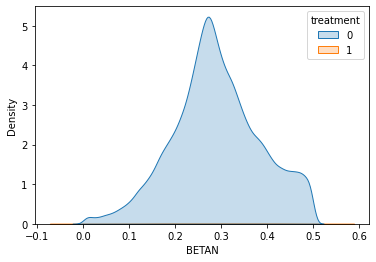

In [ ]:
sns.kdeplot(data=X_12, x="BETAN",  hue="treatment", fill=True)

KeyboardInterrupt: ignored

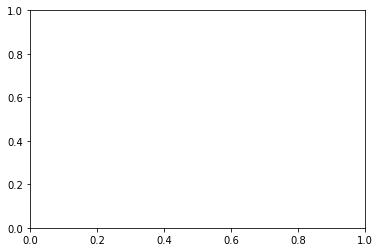

In [ ]:
sns.kdeplot(data=X_12, x="BETAN", y="propensity_score", hue="treatment", fill=True)

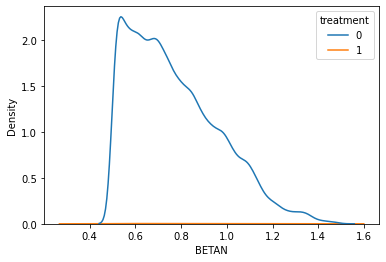

In [ ]:
sns.kdeplot(data=X_22.loc[X_22.BETAN>0.8], x="BETAN",  hue="treatment")

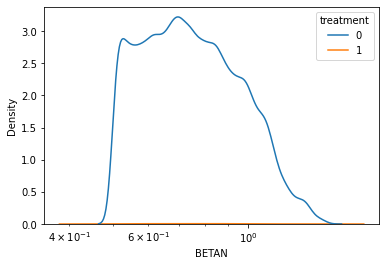

In [ ]:
sns.kdeplot(data=X_22, x="BETAN",  hue="treatment")

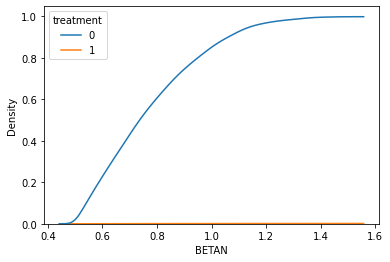

In [ ]:
sns.kdeplot(
    data=X_22, x="BETAN",  hue="treatment",
    cumulative=True, common_norm=True, common_grid=True,
)

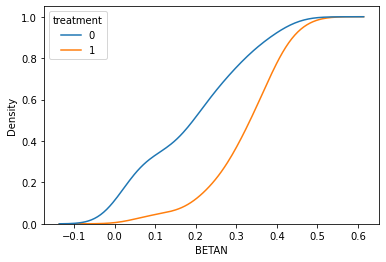

In [ ]:
sns.kdeplot(
    data=X_12, x="BETAN",  hue="treatment",
    cumulative=True, common_norm=False, common_grid=True,
)

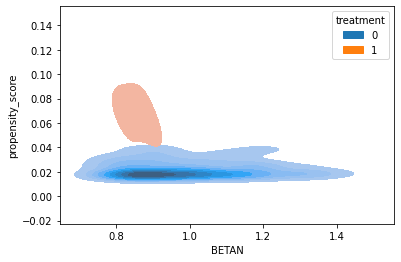

In [ ]:
sns.kdeplot(data=X_22], x="BETAN", y="propensity_score", hue="treatment", fill=True,)

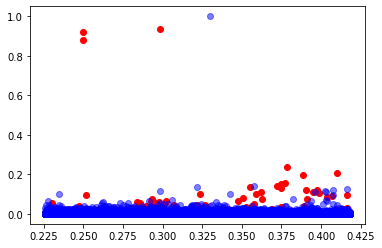

In [ ]:
plt.scatter(X_12.BETAN.loc[X_12.treatment == 1], X_12.propensity_score[X_12.treatment == 1], marker='o', c="r", alpha=1)
plt.scatter(X_12.BETAN.loc[X_12.treatment == 0], X_12.propensity_score[X_12.treatment == 0], marker='o', c="b", alpha=0.5)

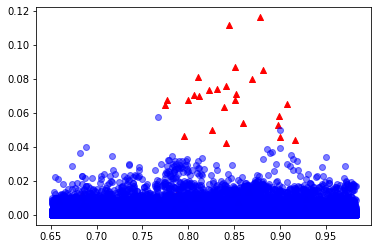

In [ ]:
plt.scatter(X_22.BETAN.loc[X_22.treatment == 1], X_22.propensity_score[X_22.treatment == 1], marker='^', c="r", alpha=1)
plt.scatter(X_22.BETAN.loc[X_22.treatment == 0], X_22.propensity_score[X_22.treatment == 0], marker='o', c="b", alpha=0.5)

KeyboardInterrupt: ignored

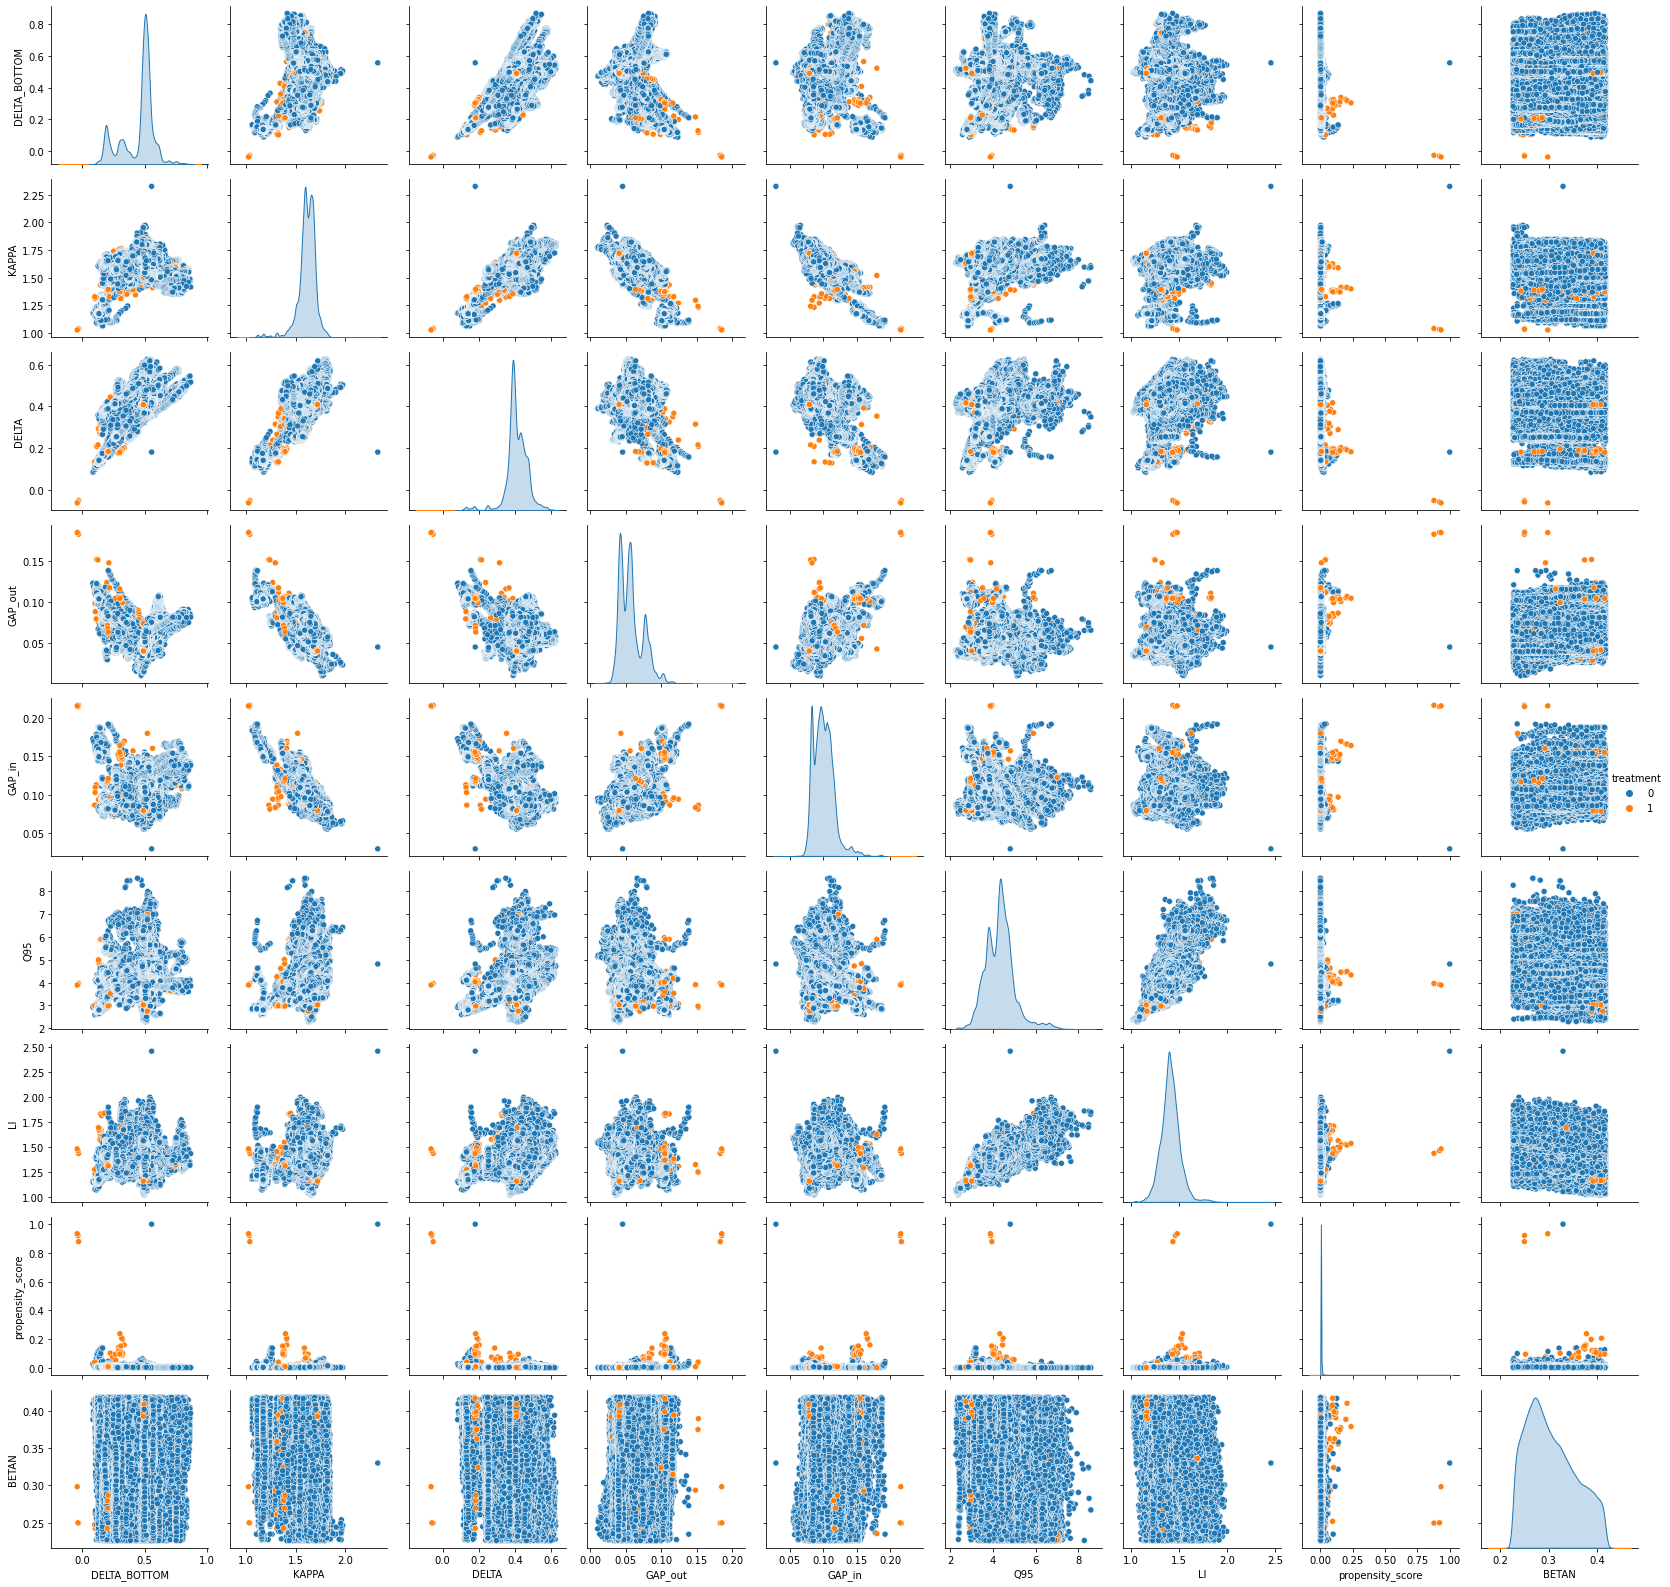

In [ ]:
sns.pairplot(data=X_12,  hue="treatment")

In [ ]:
sns.pairplot(data=X_22, hue="treatment")

In [ ]:
X = pd.concat([all_data[params].iloc[ii], all_data[params].iloc[jj_50]]).sort_index()
Y = X[param[1]] # GAP out
if Y.name == 'BETAN':
  range_ = [0, 1.5]
if Y.name == 'KAPPA':
  range_ = [0.8, 2.0]
if Y.name == 'GAP_in':
  range_ = [0.05, 0.25]
if Y.name == 'GAP_out':
  range_ = [0, 0.2]
if Y.name == 'Q95':
  range_ = [2, 7.5]
if Y.name == 'I_P':
  range_ = [-1.5e6, 1.5e6]
if Y.name == 'DELTA':
  DELTA_range = [-0.2, 0.8]
if Y.name == 'DELTA_TOP':
  DELTA_TOP_range = [-0.2, 0.8]
if Y.name == 'DELTA_BOTTOM':
  DELTA_BOTTOM_range = [-0.2 ,0.8]
if Y.name == 'LI':
  range_ = [ 0.75, 2.25] 
range_split = (range_[0]+range_[1])/3
Y_1 = Y.loc[(Y>=range_[0]) & (Y<=range_split)]
Y_2 = Y.loc[(Y>range_split) & (Y<=range_[1])]
D_1 = D[Y_1.index]  # if index is in jj_50 - than 1, if not - 0
D_2 = D[Y_2.index]  # if index is in jj_50 - than 1, if not - 0
X_1 = X[X.index.isin(Y_1.index)]
X_2 = X[X.index.isin(Y_2.index)]
X_1 = X_1.drop(param[0], axis=1)
cm_1 = CausalModel(Y_1.values, D_1.values, X_1.values)
print(f"{range_[0]} < Y < {range_split}")
print(cm_1.summary_stats)
X_2 = X_2.drop(param[0], axis=1)
cm_2 = CausalModel(Y_2.values, D_2.values, X_2.values)
print(f"{range_[1]} > Y > {range_split}")
print(cm_2.summary_stats)

0 < Y < 0.5

Summary Statistics

                    Controls (N_c=286295)         Treated (N_t=611)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.289        0.096        0.289        0.110       -0.000

                    Controls (N_c=286295)         Treated (N_t=611)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.354        0.128        0.354        0.153        0.003
             X1        0.408        0.058        0.389        0.087       -0.252
             X2        4.495        0.867        4.270        0.986       -0.242
             X3        1.612        0.086        1.596        0.114       -0.162
             X4        0.462        0.124        0.424        0.144       -

In [ ]:
df_ndiff_1 = pd.DataFrame(cm_1.summary_stats['ndiff'], index=X_1.columns, columns={'normalized_diff'})
print(abs(df_ndiff_1).sort_values(by='normalized_diff'))
df_ndiff_2 = pd.DataFrame(cm_2.summary_stats['ndiff'],index=X_2.columns, columns={'normalized_diff'})
print(abs(df_ndiff_2).sort_values(by='normalized_diff'))

              normalized_diff
DELTA_TOP            0.003444
GAP_in               0.058485
I_P                  0.100931
KAPPA                0.162116
LI                   0.216804
Q95                  0.242241
DELTA                0.252053
DELTA_BOTTOM         0.280313
GAP_out              0.398036
              normalized_diff
GAP_in               0.079805
DELTA_TOP            0.089081
DELTA                0.091126
KAPPA                0.198040
DELTA_BOTTOM         0.232967
I_P                  0.251969
GAP_out              0.461336
LI                   0.676246
Q95                  0.740195


In [ ]:
cm_1 = CausalModel(Y_1.values, D_1.values, X_1.values)
cm_2 = CausalModel(Y_2.values, D_2.values, X_2.values)

In [ ]:
cm = [cm_1, cm_2]

In [ ]:
X_2.columns

Index(['DELTA', 'Q95', 'KAPPA', 'DELTA_BOTTOM', 'LI', 'GAP_out', 'GAP_in'], dtype='object')

In [ ]:
X_1 = X_1.drop({ 'I_P', 'DELTA_TOP'}, axis=1)
X_2 = X_2.drop({ 'I_P', 'DELTA_TOP'}, axis=1)

KeyError: ignored

In [ ]:
X_1 = X_1.drop({ 'DELTA_TOP'}, axis=1)
X_2 = X_2.drop({ 'DELTA_TOP'}, axis=1)

In [ ]:
import multiprocessing

In [ ]:
for i in cm:
  print(f'Each model propensity - {i}')
  multiprocessing.Process(i.est_propensity())
  print(i.propensity)
  print(f'Each model propensity fitted - {i}') # contains the estimated propensity score of each subject
  print(i.propensity['fitted'])
  #i.trim_s()
  #print(f'Each model cutoff - {i}')
  #print(i.cutoff)

Each model propensity - <causalinference.causal.CausalModel object at 0x7f09b109ac10>

Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -40.312      2.178    -18.512      0.000    -44.580    -36.044
            X0    -14.688      1.305    -11.252      0.000    -17.247    -12.130
            X1     -1.886      0.102    -18.485      0.000     -2.086     -1.686
            X2     16.296      1.205     13.523      0.000     13.934     18.658
            X3      2.028      0.503      4.030      0.000      1.042      3.015
            X4     10.385      0.479     21.683      0.000      9.446     11.323
            X5     70.788      4.304     16.448      0.000     62.353     79.223
            X6     19.342      4.177      4.630      0.000     11.155     27.529

Each model propensity fitted - <causalinference.causal.Causa

In [ ]:
prop_fit = [cm[0].propensity['fitted'], cm[1].propensity['fitted']]

In [ ]:
for i in cm:
  #print(i.summary_stats)
  print("Stratifying")
  i.stratify_s()
  print(i.strata)

  '''for j in i.strata:
    j.est_via_ols(adj=1)
    print(j.estimates)'''

Stratifying

Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.000     0.001    143318       136     0.001     0.001    -0.008
         2     0.001     0.002     71649        77     0.002     0.002    -0.012
         3     0.002     0.004     35769        94     0.003     0.003     0.013
         4     0.004     0.005     17879        53     0.004     0.005     0.036
         5     0.005     0.006      4471        12     0.006     0.006     0.020
         6     0.006     0.008      4452        31     0.007     0.007     0.055
         7     0.008     0.011      4440        43     0.009     0.009     0.015
         8     0.011     0.014      2203        38     0.012     0.012     0.028
         9     0.014     0.019      1098        23     0.016     0.017  

In [ ]:
X_1['propensity_score'] = cm[0].propensity['fitted']
X_2['propensity_score'] = cm[1].propensity['fitted']

In [ ]:
stratas = [cm[0].strata[11], cm[1].strata[7]]
print(stratas[0].summary_stats) #we chose strata with the biggest Propensity score
print(stratas[1].summary_stats) #we chose strata with the biggest Propensity score


Summary Statistics

                       Controls (N_c=212)          Treated (N_t=68)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.186        0.136        0.322        0.096        0.137

                       Controls (N_c=212)          Treated (N_t=68)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.319        0.148        0.247        0.108       -0.554
             X1        4.808        1.588        4.284        0.515       -0.444
             X2        1.509        0.245        1.470        0.155       -0.192
             X3        0.311        0.171        0.225        0.111       -0.595
             X4        1.732        0.331        1.568        0.158       -0.632
      

In [ ]:
X_1['BETAN']=Y_1
X_2['BETAN']=Y_2

In [ ]:
ind_prop1 = X_1.loc[X_1.propensity_score>0.035].index
ind_prop2 = X_2.loc[X_2.propensity_score>0.016].index
D_12 = D[ind_prop1]  # if index is in jj_50 - than 1, if not - 0
D_22 = D[ind_prop2]  # if index is in jj_50 - than 1, if not - 0
X_12 = X[X.index.isin(ind_prop1)]
X_22 = X[X.index.isin(ind_prop2)]
Y_12 = Y[ind_prop1]
Y_22 = Y[ind_prop2]
X_12 = X_1.loc[X_1.propensity_score>0.035]
X_22 = X_2.loc[X_2.propensity_score>0.016]

In [ ]:
cm_prop = [CausalModel(Y_12.values, D_12.values, X_12.values), CausalModel(Y_22.values, D_22.values, X_22.values)]

In [ ]:
for i in cm_prop:
  print(i.summary_stats)
  #i.est_via_matching(bias_adj=True)
  #print(i.estimates)


Summary Statistics

                       Controls (N_c=218)          Treated (N_t=69)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.187        0.137        0.320        0.096        0.134

                       Controls (N_c=218)          Treated (N_t=69)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.320        0.147        0.249        0.108       -0.549
             X1        4.803        1.575        4.284        0.511       -0.443
             X2        1.511        0.243        1.471        0.155       -0.196
             X3        0.311        0.170        0.225        0.110       -0.601
             X4        1.730        0.329        1.568        0.157       -0.627
      

In [ ]:
df_ndiff_12 = pd.DataFrame(cm_prop[0].summary_stats['ndiff'],index=X_12.columns, columns={'normalized_diff'})
print(abs(df_ndiff_12).sort_values(by='normalized_diff'))
df_ndiff_22 = pd.DataFrame(cm_prop[1].summary_stats['ndiff'],index=X_22.columns, columns={'normalized_diff'})
print(abs(df_ndiff_22).sort_values(by='normalized_diff'))

                  normalized_diff
KAPPA                    0.196081
propensity_score         0.202483
GAP_out                  0.219638
GAP_in                   0.239297
Q95                      0.443397
DELTA                    0.548508
DELTA_BOTTOM             0.601234
LI                       0.626628
BETAN                    1.128431
                  normalized_diff
KAPPA                    0.054822
BETAN                    0.071514
GAP_in                   0.229346
DELTA                    0.467663
LI                       0.544179
Q95                      0.604961
GAP_out                  0.655708
propensity_score         0.693105
DELTA_BOTTOM             0.923679


In [ ]:
X_12['treatment'] = D_12
X_22['treatment'] = D_22
X_12['BETAN'] = Y_12
X_22['BETAN'] = Y_22

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
print("Stratifying")
for i in stratas:
  if i == stratas[0]:
    i.blocks = [0, 0.3, 1]
  if i == stratas[1]:
    i.blocks = [0, 6.298182074773867e-19, 1]  
  i.stratify()
  print("Stratifying")
  print(i.strata)
  print("Statistics for stratas")
  print(i.strata[0].summary_stats)
  print(i.strata[1].summary_stats)

Stratifying
Stratifying

Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.000     0.296       501        16     0.037     0.106     0.054
         2     0.308     0.911        13        30     0.475     0.653     0.175

Statistics for stratas

Summary Statistics

                       Controls (N_c=501)          Treated (N_t=16)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.133        0.135        0.187        0.119        0.054

                       Controls (N_c=501)          Treated (N_t=16)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------

ValueError: ignored

In [ ]:
print(stratas[0].strata[0].summary_stats)
print(stratas[0].strata[1].summary_stats)


Summary Statistics

                       Controls (N_c=339)           Treated (N_t=8)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.160        0.130        0.186        0.103        0.026

                       Controls (N_c=339)           Treated (N_t=8)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.320        0.130        0.330        0.085        0.086
             X1        4.580        1.269        4.332        0.701       -0.241
             X2        0.354        0.198        0.359        0.181        0.027
             X3        1.716        0.268        1.685        0.164       -0.140
             X4        0.081        0.031        0.065        0.021       -0.636


Summ